In [2]:
import numpy as np 
import pandas as pd
import torch 
import matplotlib.pylab as plt 
from matplotlib import cm
import flowtorch.bijectors as bij
import flowtorch.distributions as dist
from getdist import plots, MCSamples
from src.utils import dill_load
import getdist
import random 
import tqdm 
import emcee 
import os

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

color1 = "#50C878" 
color2 = "#222E50"
color3 = cm.tab10.colors[0]
color4 = cm.tab10.colors[1]
settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3}

In [24]:
class SampleLoader:
    def __init__(self, fname):
        df = pd.read_csv(f'samples/{fname}.csv', index_col=0)
        self.samples = df.values
        self.columns = list(df.columns)
        self.name = fname
    
    def __str__(self):
        return self.name
        
class TransForm:

    def __init__(self, samples):
        
        self.ndim = samples.shape[1]
        self.samples = samples
        self.cov_train = np.cov(samples.T)
        self.cholesky = np.linalg.cholesky(self.cov_train)
        self.cholesky_inv = np.linalg.inv(self.cholesky)
        self.mean = np.mean(samples, axis = 0).reshape(-1, self.ndim)
        
    def forward(self, testpoint):
        testpoint = testpoint.reshape(-1, self.ndim)
        testtrans = self.cholesky_inv @ (testpoint - self.mean).T
        return testtrans.T

    def inverse(self, prediction):
        prediction = prediction.reshape(-1, self.ndim)
        predtrans = self.cholesky @ prediction.T + self.mean.T
        return predtrans.T
        
def create_dataset(samples, nsamples=None):
    mean_np = np.median(samples, axis = 0)
    std_np = np.std(samples, axis = 0)
    
    if nsamples is not None:
        nsamples_original = samples.shape[0]
        idx = random.sample(range(1, nsamples_original), nsamples)
        samples = samples[idx]
        
    dataset = torch.tensor(samples, dtype=torch.float)
    mean = torch.tensor(mean_np, dtype=torch.float)
    std = torch.tensor(std_np, dtype=torch.float)
    return dataset, mean, std

def build_network(hidden=(32, 32, 32)):
    """Creates a function to do the mapping

    Args:
        hidden (tuple, optional): Number of hidden layers. Defaults to (32, 32, 32).

    Returns:
        flowtorch.lazy.lazy: a composition of bijectors
    """

    transforms = bij.Compose(
        bijectors=[
            bij.AffineAutoregressive(
                params.DenseAutoregressive(hidden_dims=hidden, nonlinearity=nn.Tanh),
            ),
            bij.AffineAutoregressive(
                params.DenseAutoregressive(hidden_dims=hidden, nonlinearity=nn.Tanh),
            ),
            bij.AffineAutoregressive(
                params.DenseAutoregressive(hidden_dims=hidden, nonlinearity=nn.Tanh),
            ),
        ]
    )
    return transforms
    
class NormFlow(TransForm, SampleLoader):
    def __init__(self, experiment: str, nsamples=None, nstd = 1):

        SampleLoader.__init__(self, experiment)
        TransForm.__init__(self, self.samples)
        data = TransForm.forward(self, self.samples)
        self.dataset, self.fiducial, self.std = create_dataset(data, nsamples)
        
        dist_x = torch.distributions.Independent(torch.distributions.Normal(self.fiducial, nstd*self.std), 1)
        bijector = build_network(hidden=(16, 16, 16))
        self.dist_y = dist.Flow(dist_x, bijector)
        
    def training(self, lr=5E-3, nsteps = 1000):
        optimizer = torch.optim.Adam(self.dist_y.parameters(), lr=lr)
        record = []
        with tqdm.trange(nsteps) as bar:
            for step in bar:
                optimizer.zero_grad()
                loss = -self.dist_y.log_prob(self.dataset).mean()
                loss.backward()
                optimizer.step()
                record.append(loss.item())
                postfix = dict(Loss=f"{loss.item():.3f}")
                bar.set_postfix(postfix)
        return record
            
    def generate_samples(self, nsamples):
        gen_samples = self.dist_y.sample(torch.Size([nsamples,])).detach().numpy()
        gen_samples = TransForm.inverse(self, gen_samples)
        return gen_samples

    def loglike(self, parameter):
        parameter = TransForm.forward(self, parameter)
        p_tensor = torch.tensor(parameter, dtype=torch.float)
        return self.dist_y.log_prob(p_tensor).detach().numpy() + np.log(np.linalg.det(self.cholesky_inv))

def build_flow(experiment, nsamples=None, lr=5E-3, nsteps=1000):
    flow = NormFlow(experiment, nsamples)
    loss = flow.training(lr, nsteps)
    os.makedirs('flows', exist_ok=True)
    torch.save(flow, f'flows/{experiment}.pt')
    return flow

def load_flow(experiment):
    flow = torch.load(f'flows/{experiment}.pt')
    return flow

def triangle_plot(samples1, samples2, label1, label2, fname):

    settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3}
    color1 = "#50C878" 
    color2 = "#222E50"
    
    ndim = 5
    names = ["x%s"%i for i in range(ndim)]
    labels = [
        r"$\sigma_{8}$",
        r"$\Omega_{c}$",
        r"$\Omega_{b}$",
        r"$h$",
        r"$n_{s}$"]
    
    samples_1 = MCSamples(samples=samples1, names = names, labels = labels, label = label1, settings = settings)
    samples_2 = MCSamples(samples=samples2, names = names, labels = labels, label = label2, settings = settings)
 
    G = plots.getSubplotPlotter(subplot_size=1.0)
    G.settings.solid_contour_palefactor = 0.9
    G.settings.alpha_filled_add = 0.9
    G.settings.num_plot_contours = 2
    G.settings.lw_contour = 1
    G.settings.axes_fontsize = 15
    G.settings.lab_fontsize = 15
    G.settings.fontsize = 35  # important for padding in x-axis
    G.settings.legend_fontsize = 15
    samples_1.updateSettings({"contours": [0.68, 0.95]})
    samples_2.updateSettings({"contoburs": [0.68, 0.95]})
    G.triangle_plot(
        [samples_1, samples_2],
        filled=[True, False],
        contour_colors=[color1, color2],
        contour_lws=[2, 2],
        contour_ls=["-", "-"],
    )
    os.makedirs('plots', exist_ok=True)
    plt.savefig(f'plots/{fname}.pdf', transparent = False, bbox_inches = 'tight')
    plt.close()

In [12]:
DES_flow = build_flow('oxford_des_y1', nsamples=15000, nsteps = 1000)

100%|██████████████████████████████████████████████████████████████| 1000/1000 [05:01<00:00,  3.32it/s, Loss=6.455]


In [13]:
DES_flow_samples = DES_flow.generate_samples(50000)

In [14]:
ndim = 5
names = ["x%s"%i for i in range(ndim)]
labels = [
    r"$\sigma_{8}$",
    r"$\Omega_{c}$",
    r"$\Omega_{b}$",
    r"$h$",
    r"$n_{s}$"]
samples_1 = MCSamples(samples=DES_flow.samples,names = names, labels = labels, label = 'DES Y1', settings = settings)
samples_2 = MCSamples(samples=DES_flow_samples,names = names, labels = labels, label='DES Y1 (Flow)', settings = settings)

Removed no burn in
Removed no burn in


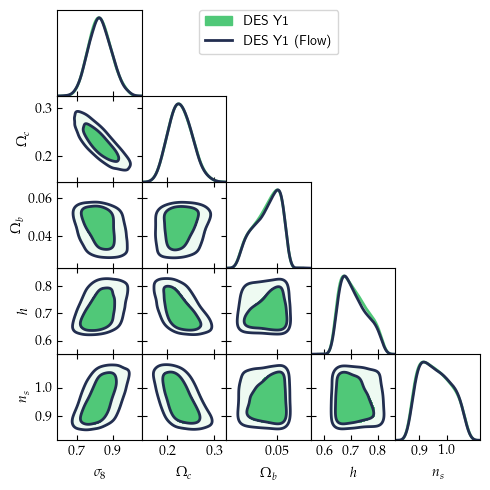

In [15]:
G = plots.getSubplotPlotter(subplot_size=1.0)
G.settings.solid_contour_palefactor = 0.9
G.settings.alpha_filled_add = 0.9
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.fontsize = 35  # important for padding in x-axis
G.settings.legend_fontsize = 15
samples_1.updateSettings({"contours": [0.68, 0.95]})
samples_2.updateSettings({"contoburs": [0.68, 0.95]})
G.triangle_plot(
    [samples_1, samples_2],
    filled=[True, False],
    contour_colors=[color1, color2],
    contour_lws=[2, 2],
    contour_ls=["-", "-"],
)
# plt.savefig('plots/triangle_plot_comparison_des.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

# Planck 

In [47]:
Planck_flow=build_flow('base_plikHM_TTTEEE_lowl_lowE', nsamples=15000, nsteps = 1000)

100%|██████████████████████████████████████████████████████████████| 1000/1000 [05:56<00:00,  2.80it/s, Loss=6.629]


In [48]:
Planck_flow_samples = Planck_flow.generate_samples(50000)

In [49]:
samples_1_planck = MCSamples(samples=Planck_flow.samples,names = names, labels = labels, label = 'Planck', settings = settings)
samples_2_planck = MCSamples(samples=Planck_flow_samples,names = names, labels = labels, label='Planck (Flow)', settings = settings)

Removed no burn in
Removed no burn in


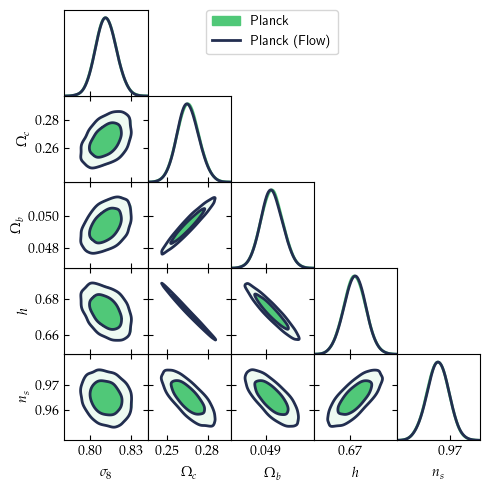

In [50]:
G = plots.getSubplotPlotter(subplot_size=1.0)
G.settings.solid_contour_palefactor = 0.9
G.settings.alpha_filled_add = 0.9
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.fontsize = 35  # important for padding in x-axis
G.settings.legend_fontsize = 15
samples_1.updateSettings({"contours": [0.68, 0.95]})
samples_2.updateSettings({"contoburs": [0.68, 0.95]})
G.triangle_plot(
    [samples_1_planck, samples_2_planck],
    filled=[True, False],
    contour_colors=[color1, color2],
    contour_lws=[2, 2],
    contour_ls=["-", "-"],
)
# plt.savefig('plots/triangle_plot_comparison_des.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

## KiDS-1000

In [20]:
kids_1000_flow=build_flow('hybrid_kids_1000', nsteps = 1000)

100%|██████████████████████████████████████████████████████████████| 1000/1000 [01:42<00:00,  9.80it/s, Loss=5.608]


In [21]:
kids_1000_flow_samples = kids_1000_flow.generate_samples(50000)

In [22]:
K1K_samples = MCSamples(samples=kids_1000_flow.samples, 
                        names = names, 
                        labels = labels, 
                        label='KiDS-1000', 
                        settings = settings)

K1K_samples_flow = MCSamples(samples=kids_1000_flow_samples, 
                             names = names, 
                             labels = labels, 
                             label='KiDS-1000 (Flow)', 
                             settings = settings)

Removed no burn in
Removed no burn in


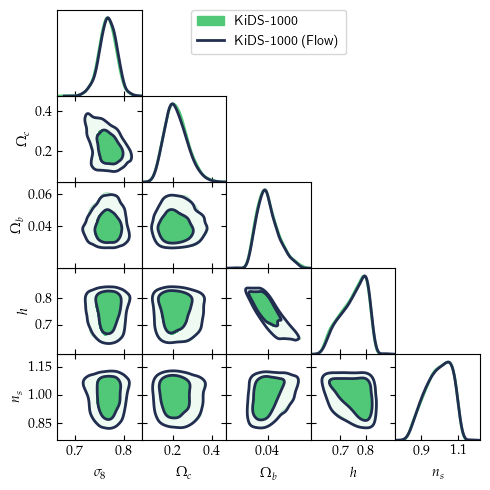

In [23]:
G = plots.getSubplotPlotter(subplot_size=1.0)
G.settings.solid_contour_palefactor = 0.9
G.settings.alpha_filled_add = 0.9
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.fontsize = 35  # important for padding in x-axis
G.settings.legend_fontsize = 15
K1K_samples.updateSettings({"contours": [0.68, 0.95]})
K1K_samples_flow.updateSettings({"contours": [0.68, 0.95]})
G.triangle_plot(
    [K1K_samples, K1K_samples_flow],
    filled=[True, False],
    contour_colors=[color1, color2],
    contour_lws=[2,2],
    contour_ls=["-", "-"],
)
# plt.savefig('plots/triangle_plot_comparison_des.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

## DES Y3

In [24]:
des_y3_flow = build_flow('hybrid_des_y3', nsteps = 1000)

100%|██████████████████████████████████████████████████████████████| 1000/1000 [01:50<00:00,  9.09it/s, Loss=5.546]


In [25]:
des_y3_flow_samples = des_y3_flow.generate_samples(50000)

In [26]:
DES_Y3_samples = MCSamples(samples=des_y3_flow.samples, 
                           names = names, 
                           labels = labels, 
                           label='DES Y3', 
                           settings = settings)

DES_Y3_samples_flow = MCSamples(samples=des_y3_flow_samples, 
                                 names = names, 
                                 labels = labels, 
                                 label='DES Y3 (Flow)', 
                                 settings = settings)

Removed no burn in
Removed no burn in


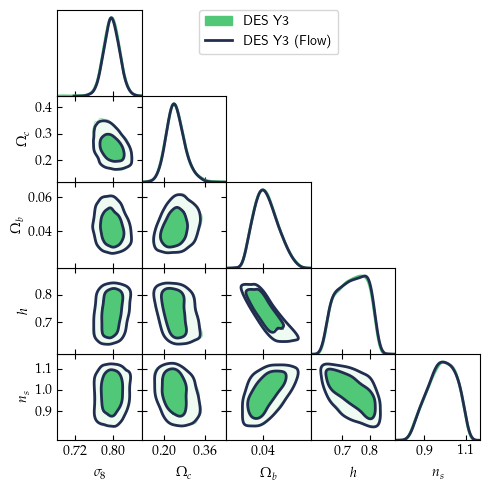

In [27]:
G = plots.getSubplotPlotter(subplot_size=1.0)
G.settings.solid_contour_palefactor = 0.9
G.settings.alpha_filled_add = 0.9
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.fontsize = 35  # important for padding in x-axis
G.settings.legend_fontsize = 15
K1K_samples.updateSettings({"contours": [0.68, 0.95]})
K1K_samples_flow.updateSettings({"contours": [0.68, 0.95]})
G.triangle_plot(
    [DES_Y3_samples, DES_Y3_samples_flow],
    filled=[True, False],
    contour_colors=[color1, color2],
    contour_lws=[2,2],
    contour_ls=["-", "-"],
)
# plt.savefig('plots/triangle_plot_comparison_des.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

# Joint

In [28]:
def loglike_flows(sample, flows):
    keys = list(flows.keys())
    logl = sum([flows[key].loglike(sample) for key in keys])
    return logl
    
class SampleFlow:
    def __init__(self, experiments: list):
        self.flows = {e:load_flow(e) for e in experiments}
        self.nexp = len(self.flows)
        self.mean = self.flows[experiments[0]].samples.mean(0) 
        self.ndim = len(self.mean)
        self.nwalkers = 2 * self.ndim
        
    def sampler(self, nsamples, eps = 1E-3):
        pos = self.mean + eps * np.random.randn(self.nwalkers, self.ndim)
        sampler = emcee.EnsembleSampler(self.nwalkers, self.ndim, loglike_flows, args=(self.flows,))
        sampler.run_mcmc(pos, nsamples, progress=True)
        return sampler

In [64]:
exp_1 = 'base_plikHM_TTTEEE_lowl_lowE' # 'hybrid_kids_1000' # 
exp_2 = 'oxford_des_y1' # 'hybrid_des_y3'# 'oxford_des_y1'
joint_flow = SampleFlow([exp_1, exp_2])

In [65]:
# sampler_flow = joint_flow.sampler(nsamples=10000)

100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [24:39<00:00,  6.76it/s]


In [66]:
samples_flow = sampler_flow.get_chain(discard = 1000, flat=True)

# Hybrid DES Y3 + KiDS-1000

In [27]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial.distance import cdist

def energy_distance_multivariate(X, Y):
    dist_within_x = cdist(X, X, 'euclidean').mean()
    dist_within_y = cdist(Y, Y, 'euclidean').mean()
    dist_between = cdist(X, Y, 'euclidean').mean()
    return (2 * dist_between - dist_within_x - dist_within_y) / (2.0 * dist_between)

def rbf_kernel_multivariate(X, Y, sigma=1.0):
    return rbf_kernel(X, Y, gamma=1/(2*sigma**2))

def compute_mmd(X, Y, sigma=1.0):
    XX = np.mean(rbf_kernel_multivariate(X, X, sigma))
    YY = np.mean(rbf_kernel_multivariate(Y, Y, sigma))
    XY = np.mean(rbf_kernel_multivariate(X, Y, sigma))
    return XX + YY - 2 * XY

class metric_calculations(TransForm):
    def __init__(self, samples_1, samples_2):
        """
        By default, samples_1 is the "known" distribution.
        """
        self.samples_1 = samples_1
        self.samples_2 = samples_2
        self.mean_1 = np.mean(samples_1, axis = 0)
        self.mean_2 = np.mean(samples_2, axis = 0)
        self.std_1 = np.std(samples_1, axis = 0)
        self.std_2 = np.std(samples_2, axis = 0)
        self.names = ['sigma_8', 'Omega_cdm', 'Omega_b', 'h', 'n_s']
        TransForm.__init__(self, samples_1)
    
    def delta_mean(self):
        print('-'*50)
        error = (np.abs((self.mean_1 - self.mean_2) / self.mean_1))
        print('delta mean')
        for i in range(5):
            print(f'{self.names[i]:<15}: {error[i]:.3f}')

    def delta_std(self):
        print('-'*50)
        error = (np.abs(self.std_1 - self.std_2) / self.std_1)
        print('delta standard deviation')
        for i in range(5):
            print(f'{self.names[i]:<15}: {error[i]:.3f}')  

    def statistics(self):
        
        print('-'*50)
        print('Samples 1 Statistics')
        for i in range(5):
            print(f'{self.names[i]:<15}: {self.mean_1[i]:.3f} \u00B1 {self.std_1[i]:.3f}')
        print('-'*50)
        print('Samples 2 Statistics')
        for i in range(5):
            print(f'{self.names[i]:<15}: {self.mean_2[i]:.3f} \u00B1 {self.std_2[i]:.3f}')
    
    def delta_quad(self):
        print('-'*50)
        error = (np.abs(self.mean_1 - self.mean_2) / np.sqrt(self.std_1**2 + self.std_2**2))
        print('Tension in 1D (Difference of Gaussians)')
        for i in range(5):
            print(f'{self.names[i]:<15}: {error[i]:.3f}')  
    
    def distance_measure(self, nsamples=2000, repeat = 1, sigma = 1.0, method = 'mmd'):
        print('-'*50)
        samples_1 = TransForm.forward(self, self.samples_1)
        samples_2 = TransForm.forward(self, self.samples_2)
        nsamples_1 = samples_1.shape[0]
        nsamples_2 = samples_2.shape[0]
        record = []
        for i in range(repeat):
            randint = idx = random.sample(range(1, min([nsamples_1, nsamples_2])), nsamples)
            samples_P = samples_1[idx]
            samples_Q = samples_2[idx]
            if method == 'mmd':
                distance = compute_mmd(samples_P, samples_Q, sigma=sigma)
            elif method == 'energy':
                distance = energy_distance_multivariate(samples_P, samples_Q)
            record.append(distance)
        mean_mmd = np.mean(record)
        std_mmd = np.std(record)
        formatted_string = f"Distance {method:<10}:"
        print(f'{formatted_string} {mean_mmd:.4f} \u00B1 {std_mmd:.4f}')
        return mean_mmd, std_mmd

def print_stats(samples_1, samples_2, nsamples=2000, nrepeat = 5, sigma = 1.0):
    metrics = metric_calculations(samples_1, samples_2)
    metrics.statistics()
    metrics.delta_mean()
    metrics.delta_std()
    metrics.delta_quad()
    mean_mmd, std_mmd = metrics.distance_measure(nsamples=nsamples, repeat=nrepeat, sigma=sigma, method='mmd')
    mean_energy, std_energy = metrics.distance_measure(nsamples=nsamples, repeat=nrepeat, sigma=sigma, method='energy')

In [199]:
# samples_P = np.random.randn(5000, 5)
# samples_Q = samples_P # np.random.randn(5000, 5) + 0.01
# print_stats(samples_P, samples_Q)

In [159]:
hybrid_des_kids = np.loadtxt('originalsamples/known-cross/chain_desy3_and_kids1000_hybrid_analysis.txt')[:,[22, 18, 19, 20, 21]]
hybrid_des_kids[:,1] = hybrid_des_kids[:,1] / hybrid_des_kids[:,3]**2
hybrid_des_kids[:,2] = hybrid_des_kids[:,2] / hybrid_des_kids[:,3]**2
hybrid_samples_known = hybrid_des_kids[len(hybrid_des_kids)//2:]

ndim = 5
names = ["x%s"%i for i in range(ndim)]
labels = [
    r"$\sigma_{8}$",
    r"$\Omega_{c}$",
    r"$\Omega_{b}$",
    r"$h$",
    r"$n_{s}$"]

samples_known = MCSamples(samples=hybrid_samples_known, 
                           names = names, 
                           labels = labels, 
                           label='KiDS 1000 + DES Y3 (Known)', 
                           settings = settings)

Removed no burn in


In [160]:
sampler_flow = dill_load('mcmcsamples', 'hybrid_des_y3_kids_1000')
samples_flow = sampler_flow.get_chain(discard = 500, flat = True)

samples_joint = MCSamples(samples=samples_flow, 
                          names = names, 
                          labels = labels, 
                          label='KiDS 1000 + DES Y3 (Flow)', 
                          settings = settings)

Removed no burn in


In [161]:
print_stats(hybrid_samples_known, samples_flow, nsamples=3000, sigma=3.0)

--------------------------------------------------
Samples 1 Statistics
sigma_8        : 0.782 ± 0.015
Omega_cdm      : 0.232 ± 0.034
Omega_b        : 0.041 ± 0.006
h              : 0.746 ± 0.048
n_s            : 0.975 ± 0.063
--------------------------------------------------
Samples 2 Statistics
sigma_8        : 0.784 ± 0.012
Omega_cdm      : 0.231 ± 0.028
Omega_b        : 0.040 ± 0.006
h              : 0.751 ± 0.044
n_s            : 0.986 ± 0.057
--------------------------------------------------
delta mean
sigma_8        : 0.002
Omega_cdm      : 0.004
Omega_b        : 0.006
h              : 0.007
n_s            : 0.011
--------------------------------------------------
delta standard deviation
sigma_8        : 0.189
Omega_cdm      : 0.177
Omega_b        : 0.012
h              : 0.070
n_s            : 0.101
--------------------------------------------------
Tension in 1D (Difference of Gaussians)
sigma_8        : 0.100
Omega_cdm      : 0.021
Omega_b        : 0.029
h              : 0

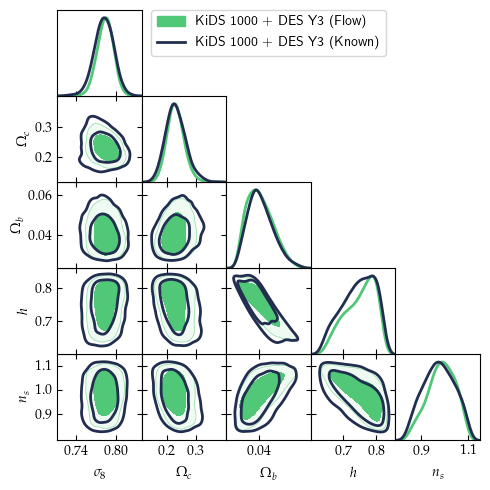

In [125]:
G = plots.getSubplotPlotter(subplot_size=1.0)
G.settings.solid_contour_palefactor = 0.9
G.settings.alpha_filled_add = 0.9
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.fontsize = 35  # important for padding in x-axis
G.settings.legend_fontsize = 15
samples_known.updateSettings({"contours": [0.68, 0.95]})
samples_joint.updateSettings({"contours": [0.68, 0.95]})
G.triangle_plot(
    [samples_joint, samples_known],
    filled=[True, False],
    contour_colors=[color1, color2],
    contour_lws=[2, 2],
    contour_ls=["-", "-"],
)
# plt.savefig('plots/triangle_plot_comparison_public_kids_1000_des_y3.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

# FD and Planck 2018

In [221]:
COLS = ['sigma8', 'Omega_cdm', 'Omega_b', 'h', 'n_s'] 

In [223]:
joint_flow = dill_load('mcmcsamples', 'P18_FD')
joint_flow_samples = joint_flow.get_chain(flat=True, discard=500)

In [224]:
def process_samples_FD_P18(save=False, burnin=None, thin=None):

    fname = 'FD_Garcia-Garcia2021_dzMarg_mMarg_P18_lcdm_nu' 
    columns = [43, 3, 4, 5, 6]
    record = []
    for i in range(4):
        samples = np.loadtxt(f'originalsamples/{fname}/{fname}.{i+1}.txt')
        cosmologies = samples[:,columns]
        if burnin is not None:
            start = int(cosmologies.shape[0] * burnin)
            cosmologies = cosmologies[start:]
        if thin is not None:
            cosmologies = cosmologies[0::thin]
        record.append(cosmologies)
    record = np.concatenate(record)
    df = pd.DataFrame(record, columns=COLS)
    print(f'Total number of samples for Oxford Full Dataset + Planck is: {df.shape[0]}')
    if save:
        df.to_csv(f'samples/{fname}.csv')
    return df

In [225]:
joint_known = process_samples_FD_P18(save=False, burnin=0.5)

Total number of samples for Oxford Full Dataset + Planck is: 23120


In [226]:
joint_known.head()

,sigma8,Omega_cdm,Omega_b,h,n_s
0,0.808671,0.257774,0.048797,0.679010,0.966592
1,0.808671,0.257774,0.048797,0.679010,0.966592
2,0.808922,0.257385,0.048750,0.679641,0.971857
3,0.807553,0.252118,0.048270,0.684222,0.973819
4,0.806539,0.249845,0.048033,0.685979,0.974790


In [227]:
print_stats(joint_known.values, joint_flow_samples, nsamples=3000, sigma=3.0)

--------------------------------------------------
Samples 1 Statistics
sigma_8        : 0.804 ± 0.005
Omega_cdm      : 0.257 ± 0.004
Omega_b        : 0.049 ± 0.000
h              : 0.680 ± 0.004
n_s            : 0.969 ± 0.004
--------------------------------------------------
Samples 2 Statistics
sigma_8        : 0.802 ± 0.005
Omega_cdm      : 0.258 ± 0.004
Omega_b        : 0.049 ± 0.000
h              : 0.679 ± 0.003
n_s            : 0.969 ± 0.004
--------------------------------------------------
delta mean
sigma_8        : 0.003
Omega_cdm      : 0.005
Omega_b        : 0.002
h              : 0.001
n_s            : 0.000
--------------------------------------------------
delta standard deviation
sigma_8        : 0.000
Omega_cdm      : 0.142
Omega_b        : 0.129
h              : 0.141
n_s            : 0.022
--------------------------------------------------
Tension in 1D (Difference of Gaussians)
sigma_8        : 0.291
Omega_cdm      : 0.214
Omega_b        : 0.159
h              : 0

In [312]:
ndim = 5
names = ["x%s"%i for i in range(ndim)]
labels = [
    r"$\sigma_{8}$",
    r"$\Omega_{c}$",
    r"$\Omega_{b}$",
    r"$h$",
    r"$n_{s}$"]

samples_flow = MCSamples(samples=joint_flow_samples, 
                           names = names, 
                           labels = labels, 
                           label='Full Dataset + Planck 2018 (Flow)', 
                           settings = settings)

samples_known = MCSamples(samples=joint_known.values, 
                          names = names, 
                          labels = labels, 
                          label='Full Dataset + Planck 2018 (Known)', 
                          settings = settings)

Removed no burn in
Removed no burn in


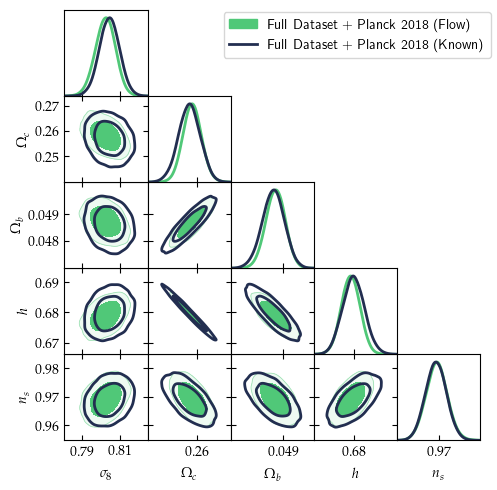

In [313]:
G = plots.getSubplotPlotter(subplot_size=1.0)
G.settings.solid_contour_palefactor = 0.9
G.settings.alpha_filled_add = 0.9
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.fontsize = 35  # important for padding in x-axis
G.settings.legend_fontsize = 15
samples_flow.updateSettings({"contours": [0.68, 0.95]})
samples_known.updateSettings({"contours": [0.68, 0.95]})
G.triangle_plot(
    [samples_flow, samples_known],
    filled=[True, False],
    contour_colors=[color1, color2],
    contour_lws=[2, 2],
    contour_ls=["-", "-"],legend_loc=(0.45, 0.88)
)
# plt.savefig('plots/triangle_plot_comparison_fd_p18.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

## Check log-likelihood

In [11]:
def load_flow(experiment: str):
    """Load a pre-trained normalising flow.

    Args:
        experiment (str): name of the experiment (flow)

    Returns:
        NormFlow: the pre-trained normalising flow
    """
    fullpath = f"flows/{experiment}.pt"
    flow = torch.load(fullpath)
    return flow

In [12]:
p18_flow = load_flow('P18_lcdm_nu')
fd_flow = load_flow('FD_Garcia-Garcia2021_dzMarg_mMarg_nu')

In [13]:
grid = np.linspace(0.75, 0.83, 500)

In [317]:
record_l1 = []
record_l2 = []
record_tot = []
for v in grid:
    point = np.copy(joint_known.values[123])
    point[0] = v
    l1 = p18_flow.loglike(point).item()
    l2 = fd_flow.loglike(point).item()
    record_l1.append(l1)
    record_l2.append(l2)
    record_tot.append(l1 + l2)

In [318]:
pdf_l1 = np.exp(record_l1)
pdf_l2 = np.exp(record_l2)
pdf_tot = np.exp(record_tot)

pdf_l1 /= np.trapz(pdf_l1, grid)
pdf_l2 /= np.trapz(pdf_l2, grid)
pdf_tot /= np.trapz(pdf_tot, grid)

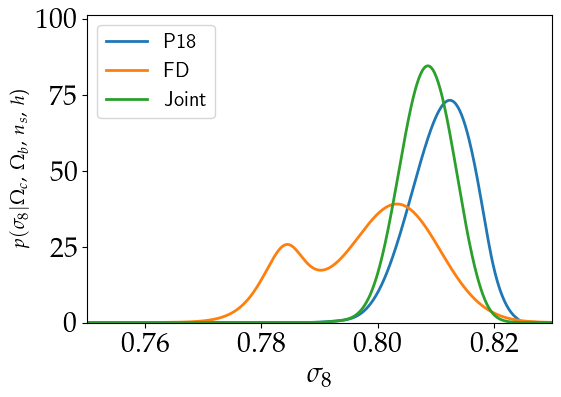

In [335]:
plt.figure(figsize=(6,4))
plt.plot(grid, pdf_l1, label = 'P18', lw = 2)
plt.plot(grid, pdf_l2, label = 'FD', lw=2)
plt.plot(grid, pdf_tot, label = 'Joint',lw=2)
plt.ylabel(r'$p(\sigma_{8}|\Omega_{c},\,\Omega_{b},\,n_{s},\,h$)', fontsize = fontSize-6)
plt.xlabel(r'$\sigma_{8}$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'upper left',prop={'family':'sans-serif', 'size':15})
plt.ylim(0.0, 1.2*max([max(pdf_l1), max(pdf_l2), max(pdf_tot)]))
plt.xlim(min(grid), max(grid))
# plt.savefig('plots/slice_density.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

# DES Y3 and KiDS-1000

In [228]:
from src.utils import dill_load

In [229]:
COLS = ['sigma8', 'Omega_cdm', 'Omega_b', 'h', 'n_s'] 

In [230]:
joint_flow = dill_load('mcmcsamples/', 'K1000_DESY3')
joint_flow_samples = joint_flow.get_chain(flat=True, discard=500)

In [231]:
def process_samples_kids_1000_des_y3(save=False, burnin=None, thin=None):

    fname = 'desy3wl_k1000_baryons_nocuts_nla_nside4096_lmax4500_lmin20_lmin100_GNG' 
    columns = [38, 37, 4, 5, 6]
    record = []
    for i in range(4):
        samples = np.loadtxt(f'originalsamples/{fname}/{fname}.{i+1}.txt')
        cosmologies = samples[:,columns]
        if burnin is not None:
            start = int(cosmologies.shape[0] * burnin)
            cosmologies = cosmologies[start:]
        if thin is not None:
            cosmologies = cosmologies[0::thin]
        record.append(cosmologies)
    record = np.concatenate(record)
    df = pd.DataFrame(record, columns=COLS)
    print(f'Total number of samples for Oxford KiDS-1000 and DES Y3 is: {df.shape[0]}')
    if save:
        df.to_csv(f'samples/{fname}.csv')
    return df

In [232]:
joint_known = process_samples_kids_1000_des_y3(save=False, burnin=0.6)

Total number of samples for Oxford KiDS-1000 and DES Y3 is: 219909


In [233]:
joint_known.head()

,sigma8,Omega_cdm,Omega_b,h,n_s
0,0.811994,0.237768,0.041936,0.792314,1.026949
1,0.811994,0.237768,0.041936,0.792314,1.026949
2,0.811994,0.237768,0.041936,0.792314,1.026949
3,0.811994,0.237768,0.041936,0.792314,1.026949
4,0.811994,0.237768,0.041936,0.792314,1.026949


In [234]:
print_stats(joint_known.values, joint_flow_samples, nsamples=3000, sigma=3.0)

--------------------------------------------------
Samples 1 Statistics
sigma_8        : 0.893 ± 0.064
Omega_cdm      : 0.184 ± 0.032
Omega_b        : 0.043 ± 0.009
h              : 0.749 ± 0.085
n_s            : 0.977 ± 0.052
--------------------------------------------------
Samples 2 Statistics
sigma_8        : 0.902 ± 0.060
Omega_cdm      : 0.182 ± 0.030
Omega_b        : 0.042 ± 0.008
h              : 0.741 ± 0.077
n_s            : 0.974 ± 0.048
--------------------------------------------------
delta mean
sigma_8        : 0.010
Omega_cdm      : 0.011
Omega_b        : 0.031
h              : 0.010
n_s            : 0.003
--------------------------------------------------
delta standard deviation
sigma_8        : 0.053
Omega_cdm      : 0.078
Omega_b        : 0.071
h              : 0.092
n_s            : 0.090
--------------------------------------------------
Tension in 1D (Difference of Gaussians)
sigma_8        : 0.098
Omega_cdm      : 0.045
Omega_b        : 0.106
h              : 0

In [194]:
ndim = 5
names = ["x%s"%i for i in range(ndim)]
labels = [
    r"$\sigma_{8}$",
    r"$\Omega_{c}$",
    r"$\Omega_{b}$",
    r"$h$",
    r"$n_{s}$"]

samples_flow = MCSamples(samples=joint_flow_samples, 
                           names = names, 
                           labels = labels, 
                           label='KiDS-1000+DES Y3 (Flow)', 
                           settings = settings)

samples_known = MCSamples(samples=joint_known.values, 
                          names = names, 
                          labels = labels, 
                          label='KiDS-1000+DES Y3 (Known)', 
                          settings = settings)

Removed no burn in
Removed no burn in


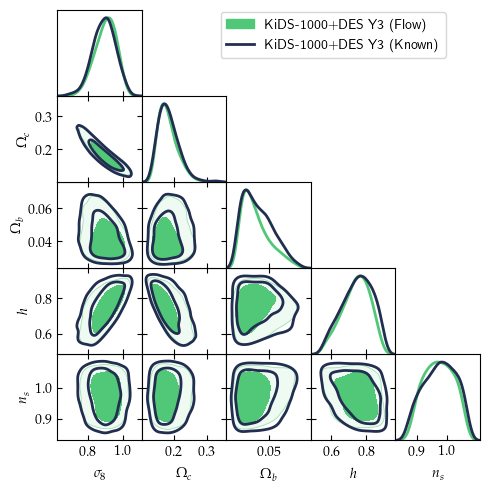

In [196]:
G = plots.getSubplotPlotter(subplot_size=1.0)
G.settings.solid_contour_palefactor = 0.9
G.settings.alpha_filled_add = 0.9
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.fontsize = 35  # important for padding in x-axis
G.settings.legend_fontsize = 15
samples_flow.updateSettings({"contours": [0.68, 0.95]})
samples_known.updateSettings({"contours": [0.68, 0.95]})
G.triangle_plot(
    [samples_flow, samples_known],
    filled=[True, False],
    contour_colors=[color1, color2],
    contour_lws=[2, 2],
    contour_ls=["-", "-"],legend_loc=(0.45, 0.88)
)
# plt.savefig('plots/triangle_plot_carlos_kids_1000_des_y3.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

# Planck 2018 + DES Y3 + KiDS-1000

In [329]:
def process_oxford_planck_2018(save=False, burnin=None, thin = None):
    fname = 'P18_lcdm_nu'
    columns = [30, 3, 4, 5, 6]
    record = []
    for i in range(6):
        samples = np.loadtxt(f'originalsamples/{fname}/{fname}.{i+1}.txt')
        cosmologies = samples[:,columns]
        if burnin is not None:
            start = int(cosmologies.shape[0] * burnin)
            cosmologies = cosmologies[start:]
        if thin is not None:
            cosmologies = cosmologies[0::thin]
        record.append(cosmologies)
    record = np.concatenate(record)
    df = pd.DataFrame(record, columns=COLS)
    print(f'Total number of samples for Oxford Planck 2018 is: {df.shape[0]}')
    if save:
        df.to_csv(f'samples/{fname}.csv')
    return df

In [330]:
planck_samples = process_oxford_planck_2018(save=False, burnin=0.5)

Total number of samples for Oxford Planck 2018 is: 23218


In [386]:
joint_flow = dill_load('mcmcsamples/', 'P18_K1000_DESY3')
joint_flow_samples = joint_flow.get_chain(flat=True, discard=500)

In [387]:
ndim = 5
names = ["x%s"%i for i in range(ndim)]
labels = [
    r"$\sigma_{8}$",
    r"$\Omega_{c}$",
    r"$\Omega_{b}$",
    r"$h$",
    r"$n_{s}$"]

samples_flow = MCSamples(samples=joint_flow_samples, 
                           names = names, 
                           labels = labels, 
                           label='Planck 2018 + KiDS-1000 + DES Y3 (Flow)', 
                           settings = settings)

samples_known = MCSamples(samples=planck_samples.values, 
                          names = names, 
                          labels = labels, 
                          label='Planck 2018 (Known)', 
                          settings = settings)

Removed no burn in
Removed no burn in


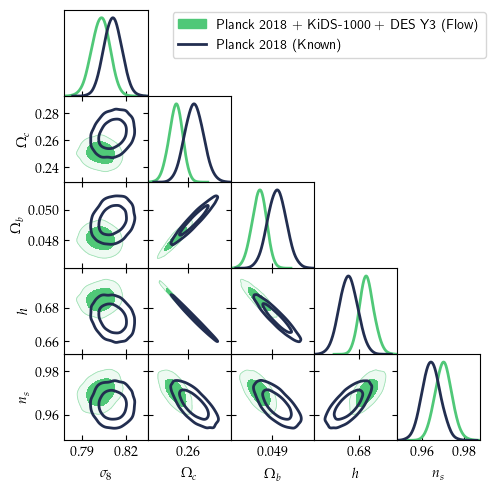

In [333]:
G = plots.getSubplotPlotter(subplot_size=1.0)
G.settings.solid_contour_palefactor = 0.9
G.settings.alpha_filled_add = 0.9
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.fontsize = 35  # important for padding in x-axis
G.settings.legend_fontsize = 15
samples_flow.updateSettings({"contours": [0.68, 0.95]})
samples_known.updateSettings({"contours": [0.68, 0.95]})
G.triangle_plot(
    [samples_flow, samples_known],
    filled=[True, False],
    contour_colors=[color1, color2],
    contour_lws=[2, 2],
    contour_ls=["-", "-"],legend_loc=(0.35, 0.88)
)
# plt.savefig('plots/triangle_plot_p18_kids_1000_des_y3.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

# Public Planck 2018 + DES Y3 + KiDS-1000

In [388]:
planck_samples = pd.read_csv('samples/base_plikHM_TTTEEE_lowl_lowE.csv', index_col=0)

In [389]:
joint_flow = dill_load('mcmcsamples', 'Public_P18_K1000_DESY3')
joint_flow_samples_public = joint_flow.get_chain(flat=True, discard=500)

In [377]:
ndim = 5
names = ["x%s"%i for i in range(ndim)]
labels = [
    r"$\sigma_{8}$",
    r"$\Omega_{c}$",
    r"$\Omega_{b}$",
    r"$h$",
    r"$n_{s}$"]

samples_flow = MCSamples(samples=joint_flow_samples_public, 
                           names = names, 
                           labels = labels, 
                           label='Planck 2018 + KiDS-1000 + DES Y3 (Flow)', 
                           settings = settings)

samples_known = MCSamples(samples=planck_samples.values, 
                          names = names, 
                          labels = labels, 
                          label='Planck 2018 (Known)', 
                          settings = settings)

Removed no burn in
Removed no burn in


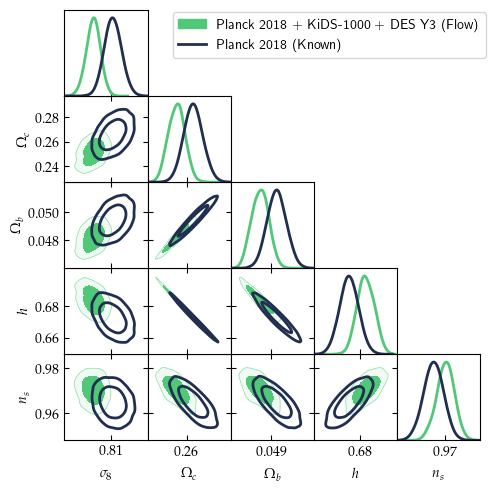

In [347]:
G = plots.getSubplotPlotter(subplot_size=1.0)
G.settings.solid_contour_palefactor = 0.9
G.settings.alpha_filled_add = 0.9
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.fontsize = 35  # important for padding in x-axis
G.settings.legend_fontsize = 15
samples_flow.updateSettings({"contours": [0.68, 0.95]})
samples_known.updateSettings({"contours": [0.68, 0.95]})
G.triangle_plot(
    [samples_flow, samples_known],
    filled=[True, False],
    contour_colors=[color1, color2],
    contour_lws=[2, 2],
    contour_ls=["-", "-"],legend_loc=(0.35, 0.88)
)
# plt.savefig('plots/triangle_plot_public_p18_kids_1000_des_y3.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

# Oxford and Public

In [390]:
diff_gaussians(joint_flow_samples_public, joint_flow_samples)

δ(sigma_8)     : 0.947
δ(Omega_cdm)   : 0.130
δ(Omega_b)     : 0.119
δ(h)           : 0.158
δ(n_s)         : 0.021
--------------------------------------------------
Samples 1
sigma_8        : 0.7948 ± 0.0061
Omega_cdm      : 0.2516 ± 0.0068
Omega_b        : 0.0482 ± 0.0006
h              : 0.6838 ± 0.0056
n_s            : 0.9703 ± 0.0040
--------------------------------------------------
Samples 2
sigma_8        : 0.8029 ± 0.0061
Omega_cdm      : 0.2505 ± 0.0052
Omega_b        : 0.0481 ± 0.0005
h              : 0.6849 ± 0.0044
n_s            : 0.9704 ± 0.0040


In [380]:
ndim = 5
names = ["x%s"%i for i in range(ndim)]
labels = [
    r"$\sigma_{8}$",
    r"$\Omega_{c}$",
    r"$\Omega_{b}$",
    r"$h$",
    r"$n_{s}$"]

samples_flow = MCSamples(samples=joint_flow_samples, 
                           names = names, 
                           labels = labels, 
                           label='Planck 2018 + KiDS-1000 + DES Y3 (Flow, Oxford)', 
                           settings = settings)

samples_flow_public = MCSamples(samples=joint_flow_samples_public, 
                          names = names, 
                          labels = labels, 
                          label='Planck 2018 + KiDS-1000 + DES Y3 (Flow, Public)', 
                          settings = settings)

Removed no burn in
Removed no burn in


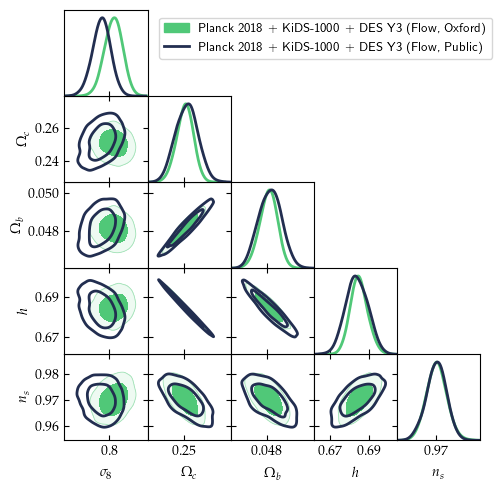

In [381]:
G = plots.getSubplotPlotter(subplot_size=1.0)
G.settings.solid_contour_palefactor = 0.9
G.settings.alpha_filled_add = 0.9
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.fontsize = 35  # important for padding in x-axis
G.settings.legend_fontsize = 14
samples_flow.updateSettings({"contours": [0.68, 0.95]})
samples_flow_public.updateSettings({"contours": [0.68, 0.95]})
G.triangle_plot(
    [samples_flow, samples_flow_public],
    filled=[True, False],
    contour_colors=[color1, color2],
    contour_lws=[2, 2],
    contour_ls=["-", "-"],legend_loc=(0.32, 0.88)
)
# plt.savefig('plots/triangle_plot_public_oxford_p18_kids_1000_des_y3.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

# Planck and ACT

In [247]:
def process_act_planck(burnin=None, thin = None):
    fname = 'originalsamples/known-cross/ACT_Planck/CLASS2p8_ACTPol_lite_DR4_Planckcomb_leakfix_yp2_baseLCDM_taup_planck2018_lowTT_plikHM_TTTEEE_hip'
    columns = [37, 6, 5, 31, 3]
    record = []
    for i in range(4):
        samples = np.loadtxt(f'{fname}.{i+1}.txt')
        cosmologies = samples[:,columns]
        if burnin is not None:
            start = int(cosmologies.shape[0] * burnin)
            cosmologies = cosmologies[start:]
        if thin is not None:
            cosmologies = cosmologies[0::thin]
        record.append(cosmologies)
    record = np.concatenate(record)
    record[:,3] /= 100
    record[:,1] /= record[:,3]**2
    record[:,2] /= record[:,3]**2
    df = pd.DataFrame(record, columns=COLS)
    print(f'Total number of samples for Planck + ACT DR4 is: {df.shape[0]}')
    return df

In [249]:
joint_flow = dill_load('mcmcsamples', 'planck_act')
joint_flow_samples = joint_flow.get_chain(flat=True, discard=500)

In [250]:
planck_samples = pd.read_csv('samples/base_plikHM_TTTEEE_lowl_lowE.csv', index_col=0).values
act_samples = pd.read_csv('samples/act_dr4_tt_te_ee.csv', index_col=0).values
planck_act_samples = process_act_planck(burnin=None, thin=None).values

Total number of samples for Planck + ACT DR4 is: 35680


In [251]:
ndim = 5
names = ["x%s"%i for i in range(ndim)]
labels = [
    r"$\sigma_{8}$",
    r"$\Omega_{c}$",
    r"$\Omega_{b}$",
    r"$h$",
    r"$n_{s}$"]

samples_flow = MCSamples(samples=joint_flow_samples, 
                           names = names, 
                           labels = labels, 
                           label='Planck 2018 + ACT DR4 (Flow)', 
                           settings = settings)

samples_planck_act_public = MCSamples(samples=planck_act_samples, 
                              names = names, 
                              labels = labels, 
                              label='Planck 2018 + ACT DR4 (Public)', 
                              settings = settings)

samples_planck_public = MCSamples(samples=planck_samples, 
                              names = names, 
                              labels = labels, 
                              label='Planck 2018 (Public)', 
                              settings = settings)

samples_act_public = MCSamples(samples=act_samples, 
                              names = names, 
                              labels = labels, 
                              label='ACT DR4 (Public)', 
                              settings = settings)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


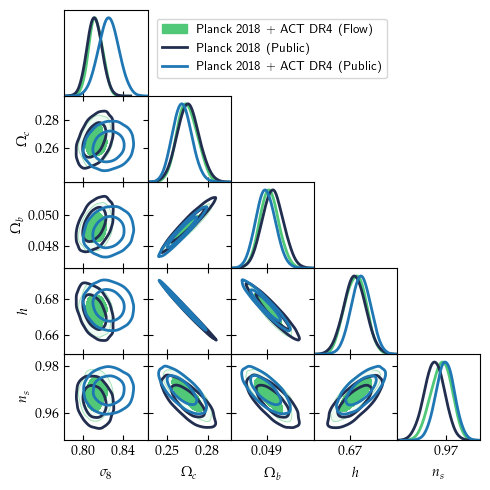

In [264]:
G = plots.getSubplotPlotter(subplot_size=1.0)
G.settings.solid_contour_palefactor = 0.9
G.settings.alpha_filled_add = 0.9
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.fontsize = 35  # important for padding in x-axis
G.settings.legend_fontsize = 14
samples_flow.updateSettings({"contours": [0.68, 0.95]})
samples_planck_act_public.updateSettings({"contours": [0.68, 0.95]})
samples_planck_public.updateSettings({"contours": [0.68, 0.95]})
samples_act_public.updateSettings({"contours": [0.68, 0.95]})
G.triangle_plot(
    [samples_flow, samples_planck_public, samples_planck_act_public],
    filled=[True, False, False],
    contour_colors=[color1, color2, color3],
    contour_lws=[2, 2, 2],
    contour_ls=["-", "-", "-"],legend_loc=(0.32, 0.84)
)
# plt.savefig('plots/triangle_plot_public_oxford_p18_kids_1000_des_y3.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

# Planck 2018 as a Prior

In this setup, we have run DES Y1 + Planck 2018, and we will compare with DES Y1 (flow) and Planck 2018 (flow). 

In [36]:
COLS = ['sigma8', 'Omega_cdm', 'Omega_b', 'h', 'n_s'] 

In [37]:
flow_sampler = dill_load('mcmcsamples', 'public_planck_oxford_des_y1')
flow_samples = flow_sampler.get_chain(flat=True, discard=500)

In [38]:
planck_samples = pd.read_csv('samples/base_plikHM_TTTEEE_lowl_lowE.csv', index_col=0)

In [39]:
def process_desy1_planck(burnin=None, thin = None):    
    
    fname = 'mcmcsamples/des_planck.1.txt'
    columns = [2, 3, 4, 5, 6]
    samples = np.loadtxt(f'{fname}')
    cosmologies = samples[:,columns]
    if burnin is not None:
        start = int(cosmologies.shape[0] * burnin)
        cosmologies = cosmologies[start:]
    if thin is not None:
        cosmologies = cosmologies[0::thin]
    df = pd.DataFrame(cosmologies, columns=COLS)
    print(f'Total number of samples for Oxford DES Y1 + Planck 2018 (flow) is: {df.shape[0]}')
    return df

In [40]:
mcmc_samples = process_desy1_planck(burnin=0.5, thin=None).values

Total number of samples for Oxford DES Y1 + Planck 2018 (flow) is: 107500


In [30]:
ndim = 5
names = ["x%s"%i for i in range(ndim)]
labels = [
    r"$\sigma_{8}$",
    r"$\Omega_{c}$",
    r"$\Omega_{b}$",
    r"$h$",
    r"$n_{s}$"]

samples_flow = MCSamples(samples=flow_samples, 
                           names = names, 
                           labels = labels, 
                           label='DES Y1 (Flow) + Planck 2018 (Flow)', 
                           settings = settings)

samples_known = MCSamples(samples=mcmc_samples, 
                          names = names, 
                          labels = labels, 
                          label='DES Y1 + Planck 2018 (Flow Prior)', 
                          settings = settings)

samples_planck = MCSamples(samples=planck_samples.values, 
                          names = names, 
                          labels = labels, 
                          label='Planck 2018 (Public)', 
                          settings = settings)

Removed no burn in
Removed no burn in
Removed no burn in


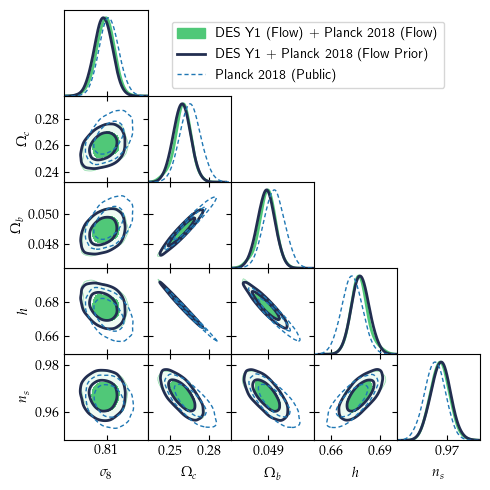

In [35]:
G = plots.getSubplotPlotter(subplot_size=1.0)
G.settings.solid_contour_palefactor = 0.9
G.settings.alpha_filled_add = 0.9
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.fontsize = 35  # important for padding in x-axis
G.settings.legend_fontsize = 15
samples_flow.updateSettings({"contours": [0.68, 0.95]})
samples_known.updateSettings({"contours": [0.68, 0.95]})
samples_planck.updateSettings({"contours": [0.68, 0.95]})
G.triangle_plot(
    [samples_flow, samples_known, samples_planck],
    filled=[True, False, False],
    contour_colors=[color1, color2, color3],
    contour_lws=[2, 2, 1],
    contour_ls=["-", "-", "--"],legend_loc=(0.35, 0.82)
)
# plt.savefig('/home/arrykrishna/Desktop/triangle_plot.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

In [28]:
print_stats(mcmc_samples, flow_samples, nsamples=3000, nrepeat = 5, sigma = 3.0)

--------------------------------------------------
Samples 1 Statistics
sigma_8        : 0.807 ± 0.007
Omega_cdm      : 0.259 ± 0.007
Omega_b        : 0.049 ± 0.001
h              : 0.678 ± 0.005
n_s            : 0.967 ± 0.004
--------------------------------------------------
Samples 2 Statistics
sigma_8        : 0.809 ± 0.007
Omega_cdm      : 0.260 ± 0.007
Omega_b        : 0.049 ± 0.001
h              : 0.678 ± 0.005
n_s            : 0.967 ± 0.004
--------------------------------------------------
delta mean
sigma_8        : 0.002
Omega_cdm      : 0.002
Omega_b        : 0.001
h              : 0.001
n_s            : 0.000
--------------------------------------------------
delta standard deviation
sigma_8        : 0.011
Omega_cdm      : 0.007
Omega_b        : 0.011
h              : 0.010
n_s            : 0.024
--------------------------------------------------
Tension in 1D (Difference of Gaussians)
sigma_8        : 0.161
Omega_cdm      : 0.068
Omega_b        : 0.073
h              : 0